# A/B Testing Analysis for Campaign Effectiveness

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency

In [3]:
# Define the zip file path
zip_file_path = 'Marketing AB Testing.zip'

# Step 1: Extract the dataset from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    extracted_files = zip_ref.namelist()  # List all files in the zip
    csv_file_name = extracted_files[0]  # Assuming the first file is the CSV
    df = pd.read_csv(zip_ref.open(csv_file_name))  # Load CSV into DataFrame

# Step 2: Basic Information about the Dataset
print("Basic Info:")
df.info()  # Shows column names, data types, and non-null counts

# Step 3: Display the First Few Rows
print("\nFirst 5 Rows of the Dataset:")
print(df.head())  # Displays a preview of the first few rows

# Step 4: Check for Missing Values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())  # Shows the number of missing values per column

# Step 5: Summary Statistics for Numerical Columns
print("\nSummary Statistics for Numerical Columns:")
print(df.describe())  # Provides mean, standard deviation, min, max, and quartiles

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB

First 5 Rows of the Dataset:
   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         a

In [4]:
# Data Cleaning

# Step 6: Remove Unnecessary Columns
df.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)  # Remove unnecessary column if it exists

# Step 7: Check and Remove Duplicate Rows
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"Number of duplicate rows found: {num_duplicates}")
    df.drop_duplicates(inplace=True)  # Remove duplicates

# Step 8: Correct Data Types
df['converted'] = df['converted'].astype(int)  # Ensure 'converted' is an integer

# Step 9: Remove Redundant Features
if 'user id' in df.columns:
    df.drop(columns=['user id'], inplace=True)  # Remove 'user id' if it exists

# Step 10: Ensure Consistent Formatting in Categorical Columns
df['test group'] = df['test group'].str.lower().str.strip()  # Standardize 'test group' values
df['most ads day'] = df['most ads day'].str.lower().str.strip()  # Standardize 'most ads day' values

# Step 11: Verify Unique Values
print(f"\nUnique values in 'test group': {df['test group'].unique()}")
print(f"Unique values in 'most ads day': {df['most ads day'].unique()}")



Unique values in 'test group': ['ad' 'psa']
Unique values in 'most ads day': ['monday' 'tuesday' 'friday' 'saturday' 'wednesday' 'sunday' 'thursday']


In [5]:
# Step 12: Feature Engineering
# Feature 1: Time of Day Segmentation
def categorize_hour(hour):
    """Categorize the hour into Morning, Afternoon, Evening, or Night."""
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    return 'Night'

df['time_of_day'] = df['most ads hour'].apply(categorize_hour)  # Create new time_of_day column

# Feature 2: Weekend or Weekday Indicator
df['is_weekend'] = df['most ads day'].apply(lambda x: 1 if x in ['saturday', 'sunday'] else 0)

# Feature 3: Ads Exposure Intensity
def ads_intensity(total_ads):
    """Categorize total ads into Low, Medium, or High based on exposure."""
    if total_ads < 10:
        return 'Low'
    elif 10 <= total_ads < 50:
        return 'Medium'
    return 'High'

df['ads_intensity'] = df['total ads'].apply(ads_intensity)  # Create new ads_intensity column


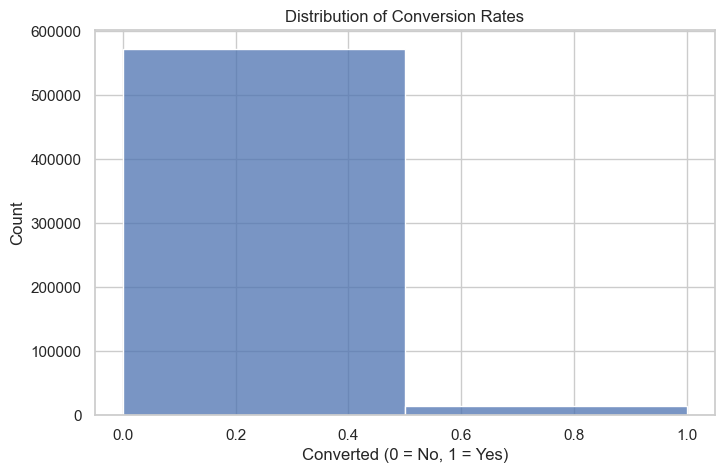

C:\Users\milto\AppData\Local\Temp\ipykernel_22012\278845236.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='test group', y='converted', data=df, ci=None)


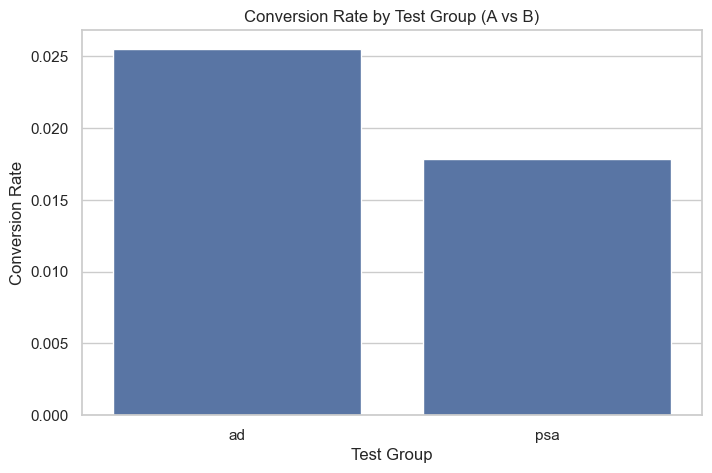

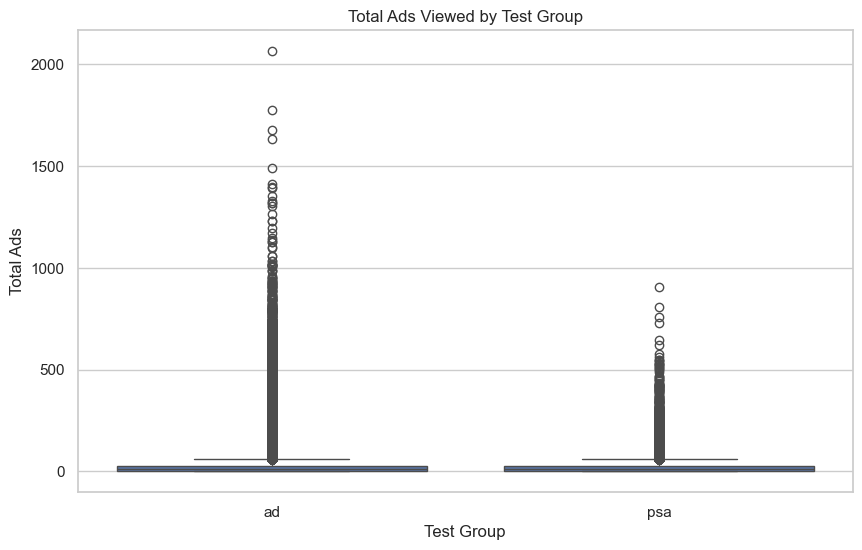

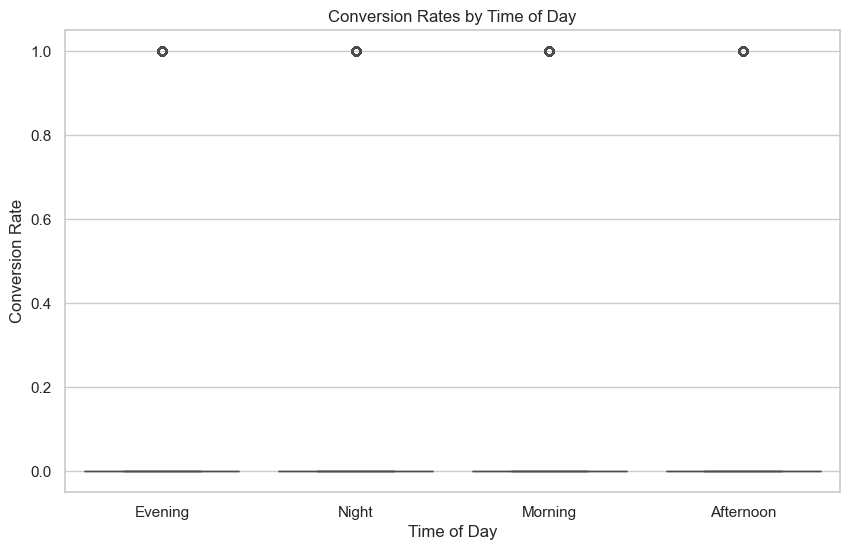

In [6]:
# Step 13: Visualizations
sns.set(style="whitegrid")

# Step 13.1: Plot Distribution of Conversion Rate
plt.figure(figsize=(8, 5))
sns.histplot(df['converted'], bins=2, kde=False)
plt.title('Distribution of Conversion Rates')
plt.xlabel('Converted (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Step 13.2: Bar Plot Comparing Conversion Rates Across Groups
plt.figure(figsize=(8, 5))
sns.barplot(x='test group', y='converted', data=df, ci=None)
plt.title('Conversion Rate by Test Group (A vs B)')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.show()

# Step 13.3: Box Plot to Compare Total Ads Between Groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='test group', y='total ads', data=df)
plt.title('Total Ads Viewed by Test Group')
plt.xlabel('Test Group')
plt.ylabel('Total Ads')
plt.show()

# Step 13.4: Box Plot to Compare Conversion Rates by Time of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='time_of_day', y='converted', data=df)
plt.title('Conversion Rates by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Conversion Rate')
plt.show()


In [7]:
# Perform A/B Test Analysis

# Step 14: Calculate Group Sizes and Metrics
group_sizes = df['test group'].value_counts()
conversion_rates = df.groupby('test group')['converted'].mean()

print("\nGroup Sizes:")
print(group_sizes)
print("\nConversion Rates by Test Group:")
print(conversion_rates)

# Step 15: Statistical Test Execution (Chi-square Test)
contingency_table = pd.crosstab(df['test group'], df['converted'])
print("\nContingency Table:")
print(contingency_table)

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square Test Results:")
print(f"Chi2 Statistic: {chi2:.4f}, P-value: {p_value:.4f}, Degrees of Freedom: {dof}")

# Interpretation of P-value
if p_value < 0.05:
    print("Result: Reject the null hypothesis (H0). There is a significant difference in conversion rates between the groups.")
else:
    print("Result: Fail to reject the null hypothesis (H0). No significant difference in conversion rates between the groups.")



Group Sizes:
test group
ad     564577
psa     23524
Name: count, dtype: int64

Conversion Rates by Test Group:
test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

Contingency Table:
converted        0      1
test group               
ad          550154  14423
psa          23104    420

Chi-square Test Results:
Chi2 Statistic: 54.0058, P-value: 0.0000, Degrees of Freedom: 1
Result: Reject the null hypothesis (H0). There is a significant difference in conversion rates between the groups.


In [8]:
# Optional: Calculate Effect Size (Cohen's h)
conversions_A = df[df['test group'] == 'ad']['converted'].sum()
conversions_B = df[df['test group'] == 'psa']['converted'].sum()
n_A = df[df['test group'] == 'ad'].shape[0]
n_B = df[df['test group'] == 'psa'].shape[0]

# Calculate Cohen's h
prop_A = conversions_A / n_A
prop_B = conversions_B / n_B
cohen_h = 2 * np.arcsin(np.sqrt(prop_A)) - 2 * np.arcsin(np.sqrt(prop_B))
cohen_h = np.abs(cohen_h)

print(f"Effect Size (Cohen's h): {cohen_h:.4f}")

# Report Findings and Recommendations
print("\nBusiness Interpretation:")
if cohen_h >= 0.2:
    print("- The 'ad' version performed significantly better with a higher conversion rate compared to 'psa'.")
else:
    print("- The observed difference was statistically significant but the practical effect size is small.")

Effect Size (Cohen's h): 0.0530

Business Interpretation:
- The observed difference was statistically significant but the practical effect size is small.
